In [61]:
# import the libraries
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, DotProduct, ConstantKernel as C
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt

In [62]:
# Load the data
tensile_df =  pd.read_excel("../Tensile_Properties_Data.xlsx", header=0, skiprows=1)
tensile_df

,Reference,Material,Material Group,C (wt.%),Si (wt.%),Mn (wt.%),P (wt.%),S (wt.%),Ni (wt.%),Cr (wt.%),...,Width (mm),Aspect Ratio (L/W),Aspect Ratio (R/W),Aspect Ratio (T/W),Test Temperature (C),Strain Rate (1/s),Yield Strength (MPa),Ultimate Tensile Strength (MPa),Uniform Elongation (%),Total Elongation (%)
0,1,SS304L,"NSM, Rector Internals",0.02,0.45,1.30,NaN,NaN,8.02,18.30,...,1.2,4.166700,1.1667,0.625000,23.0,0.001000,274.0,789.0,67.00,76.00
1,1,SS304L,"NSM, Rector Internals",0.02,0.45,1.30,NaN,NaN,8.02,18.30,...,0.8,4.437500,0.3750,0.500000,23.0,0.001000,272.0,781.0,69.00,80.00
2,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,1.2,4.166700,1.1667,0.416667,23.0,0.001000,710.0,767.0,7.90,14.80
3,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,0.8,3.187500,0.3750,0.500000,23.0,0.001000,607.0,760.0,10.80,23.10
4,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,0.8,3.187500,0.3750,0.500000,23.0,0.001000,725.0,782.0,6.60,18.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,114.0,0.222807,NaN,0.114035,760.0,0.000067,214.0,572.0,59.35,67.66
1469,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,NaN,NaN,NaN,NaN,760.0,0.000067,207.0,494.0,38.80,47.80
1470,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,NaN,NaN,NaN,NaN,760.0,0.003667,101.0,352.0,31.22,47.25
1471,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,25.0,2.032000,NaN,0.000000,760.0,0.000067,177.0,497.0,40.40,46.50


In [63]:
# Check the data information for each column.
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 56 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Reference                        1473 non-null   int64  
 1   Material                         1473 non-null   object 
 2   Material Group                   1473 non-null   object 
 3   C (wt.%)                         1210 non-null   object 
 4   Si (wt.%)                        1174 non-null   float64
 5   Mn (wt.%)                        1179 non-null   float64
 6   P (wt.%)                         1157 non-null   float64
 7   S (wt.%)                         965 non-null    float64
 8   Ni (wt.%)                        1387 non-null   float64
 9   Cr (wt.%)                        1404 non-null   float64
 10  Mo (wt.%)                        1331 non-null   float64
 11  Al (wt.%)                        484 non-null    float64
 12  N (wt.%)            

In [64]:
# Select the composition columns
compostion_cols = tensile_df.columns[3:29]
compostion_cols

Index(['C (wt.%)', 'Si (wt.%)', 'Mn (wt.%)', 'P (wt.%)', 'S (wt.%)',
       'Ni (wt.%)', 'Cr (wt.%)', 'Mo (wt.%)', 'Al (wt.%)', 'N (wt.%)',
       'Ti (wt.%)', 'Fe (wt.%)', 'Nb (wt.%)', 'B (wt.%)', 'Cu (wt.%)',
       'V (wt.%)', 'Mg (wt.%)', 'Y (wt.%)', 'Zr (wt.%)', 'Zn (wt.%)',
       'W (wt.%)', 'Sn (wt.%)', 'Co (wt.%)', 'O (wt.,%)', 'Ta (wt.%)',
       'H (wt.%)'],
      dtype='object')

In [65]:
# Fill the nan values with 0 for the comospition columns
tensile_df[compostion_cols]  = tensile_df[compostion_cols].fillna(0)
tensile_df['Irradiation Dose (mdpa)']  = tensile_df['Irradiation Dose (mdpa)'].fillna(0)
tensile_df['Irradiation Temperature (C)']  = tensile_df['Irradiation Temperature (C)'].fillna(0)

In [66]:
# Select SS316 stainless steel and sub-sized samples
tensile_df  = tensile_df[(tensile_df['Material Group'].str.contains('ss316', case=False))& (tensile_df['Specimen Size'] == 'Sub-sized')]

In [67]:
# check these columns that have noisy data. 
print('unique values for Zr (wt.%) column:' + str(tensile_df['Zr (wt.%)'].unique()))
print(100*'_')
print('unique values for C (wt.%) column:' + str(tensile_df['C (wt.%)'].unique()))
print(100*'_')
print('unique values for Fe (wt.%) column:' + str(tensile_df['Fe (wt.%)'].unique()))

unique values for Zr (wt.%) column:[0]
____________________________________________________________________________________________________
unique values for C (wt.%) column:[0.018 0.055 0.03 0.061 0.05 0.04 0.058]
____________________________________________________________________________________________________
unique values for Fe (wt.%) column:[68.052 63.537800000000004 67.9 64.94000000000001 0 58.8682
 66.80699999999999 63.4728]


In [68]:
# Clean the data
tensile_df = tensile_df[~tensile_df['Zr (wt.%)'].isin(['<','ppm','bal'])]
tensile_df = tensile_df[~tensile_df['C (wt.%)'].isin(['<','ppm','bal'])]
tensile_df = tensile_df[~tensile_df['Fe (wt.%)'].isin(['<','ppm','bal'])]


In [69]:
# Check the data again, make sure  the data is cleaned
print('unique values for Zr (wt.%) column:' + str(tensile_df['Zr (wt.%)'].unique()))
print(100*'_')
print('unique values for C (wt.%) column:' + str(tensile_df['C (wt.%)'].unique()))
print(100*'_')
print('unique values for Fe (wt.%) column:' + str(tensile_df['Fe (wt.%)'].unique()))

unique values for Zr (wt.%) column:[0]
____________________________________________________________________________________________________
unique values for C (wt.%) column:[0.018 0.055 0.03 0.061 0.05 0.04 0.058]
____________________________________________________________________________________________________
unique values for Fe (wt.%) column:[68.052 63.537800000000004 67.9 64.94000000000001 0 58.8682
 66.80699999999999 63.4728]


In [70]:
# convert all of the composition columns' data type to float
tensile_df[compostion_cols]  = tensile_df[compostion_cols].astype(float)

In [71]:
# check the data again.
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 556 entries, 21 to 989
Data columns (total 56 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Reference                        556 non-null    int64  
 1   Material                         556 non-null    object 
 2   Material Group                   556 non-null    object 
 3   C (wt.%)                         556 non-null    float64
 4   Si (wt.%)                        556 non-null    float64
 5   Mn (wt.%)                        556 non-null    float64
 6   P (wt.%)                         556 non-null    float64
 7   S (wt.%)                         556 non-null    float64
 8   Ni (wt.%)                        556 non-null    float64
 9   Cr (wt.%)                        556 non-null    float64
 10  Mo (wt.%)                        556 non-null    float64
 11  Al (wt.%)                        556 non-null    float64
 12  N (wt.%)                  

In [72]:
# Drop the columns that don't have  enough data records.

tensile_df = tensile_df.drop(columns=[ 'Reference','Manufacturing','Cooling', 'Material', 'Treatment',  'Specimen Size Type',
                                      'Irradiation Time (h)', 'Fillet Radius (mm)', 'Specimen Size', 'Specimen Shape',
                                       'Post Treatment Temperature (C)','Post Treatment Time (h)','Microstructure', 'Aspect Ratio (R/W)', 'Ultimate Tensile Strength (MPa)',
                                       'Yield Strength (MPa)', 'Total Elongation (%)','Specimen Shape'
                                       ])


In [73]:
# remove nan values from the dataset
tensile_df = tensile_df.dropna()
tensile_df = tensile_df.reset_index(drop=True)
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Material Group                86 non-null     object 
 1   C (wt.%)                      86 non-null     float64
 2   Si (wt.%)                     86 non-null     float64
 3   Mn (wt.%)                     86 non-null     float64
 4   P (wt.%)                      86 non-null     float64
 5   S (wt.%)                      86 non-null     float64
 6   Ni (wt.%)                     86 non-null     float64
 7   Cr (wt.%)                     86 non-null     float64
 8   Mo (wt.%)                     86 non-null     float64
 9   Al (wt.%)                     86 non-null     float64
 10  N (wt.%)                      86 non-null     float64
 11  Ti (wt.%)                     86 non-null     float64
 12  Fe (wt.%)                     86 non-null     float64
 13  Nb (wt.

In [74]:
# sort the data by UE values
tensile_df = tensile_df.sort_values(by='Uniform Elongation (%)').reset_index(drop=True)


In [75]:
# Select columns for modeling.

input_features_df =  tensile_df.drop(columns=['Uniform Elongation (%)'])

In [76]:
# Encode the categorical columns
input_features_df['Material Group'] = input_features_df['Material Group'].astype('category')
input_features_df['Material Group'] = input_features_df['Material Group'].cat.codes

input_features_df['Treatment – Three Categories'] = input_features_df['Treatment – Three Categories'].astype('category')
input_features_df['Treatment – Three Categories'] = input_features_df['Treatment – Three Categories'].cat.codes

In [77]:
# make sure all the input features data is float data type
input_features_df = input_features_df.astype('float')

In [78]:
# define input features and input targets
features = input_features_df
targets = tensile_df['Uniform Elongation (%)']

In [79]:
# define converage 
def coverage(y, yL, yH):
    return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

Run # 1 Fold # 1
[iter 0] loss=4.3940 val_loss=4.2289 scale=2.0000 norm=2.3229
[iter 100] loss=3.7234 val_loss=3.4411 scale=2.0000 norm=1.2085
[iter 200] loss=3.2429 val_loss=2.9953 scale=2.0000 norm=1.0154
[iter 300] loss=2.7867 val_loss=2.6542 scale=2.0000 norm=0.9681
== Early stopping achieved.
== Best iteration / VAL390 (val_loss=2.5182)
Pearson CC: 0.9916637189567121
R2 score: 0.9833908355673135
RMSE: 2.2248062752185045
MAE: 1.5473471320531877
Coverage: 100.0
Median Interval Width: 22.217070721228193
Composite Metric: 0.7612526085520863


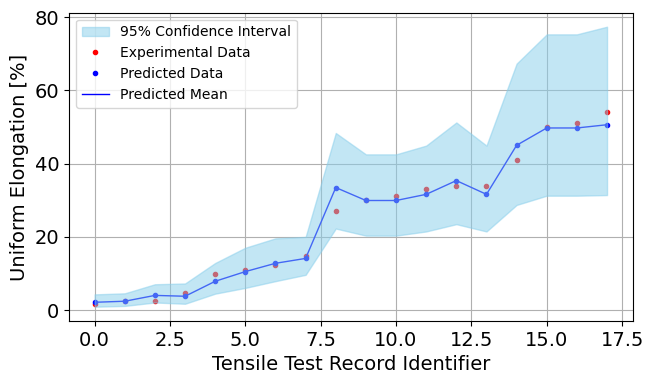

Run # 1 Fold # 2
[iter 0] loss=4.3321 val_loss=3.8623 scale=2.0000 norm=2.2487
[iter 100] loss=3.6557 val_loss=3.0327 scale=2.0000 norm=1.1885
[iter 200] loss=3.1770 val_loss=2.5880 scale=2.0000 norm=1.0037
[iter 300] loss=2.7302 val_loss=2.2121 scale=2.0000 norm=0.9530
[iter 400] loss=2.3256 val_loss=1.9327 scale=2.0000 norm=0.8957
== Early stopping achieved.
== Best iteration / VAL475 (val_loss=1.8539)
Pearson CC: 0.9889728549334342
R2 score: 0.9691904954316554
RMSE: 3.9379304217677737
MAE: 2.3219533027829065
Coverage: 100.0
Median Interval Width: 23.17937220697107
Composite Metric: 0.7607854517269805


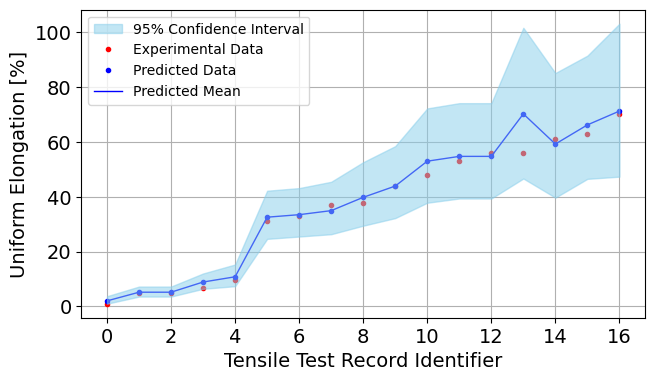

Run # 1 Fold # 3
[iter 0] loss=4.5209 val_loss=4.2234 scale=2.0000 norm=2.0657
[iter 100] loss=3.8120 val_loss=3.2445 scale=2.0000 norm=1.1310
[iter 200] loss=3.3292 val_loss=2.7655 scale=2.0000 norm=0.9864
[iter 300] loss=2.8681 val_loss=2.3578 scale=2.0000 norm=0.9467
[iter 400] loss=2.4316 val_loss=2.0688 scale=2.0000 norm=0.9076
== Early stopping achieved.
== Best iteration / VAL463 (val_loss=2.0164)
Pearson CC: 0.9725103588522052
R2 score: 0.9272143753228335
RMSE: 5.8114671003818845
MAE: 2.6720356498628113
Coverage: 94.11764705882354
Median Interval Width: 3.473170855655507
Composite Metric: 0.7778626874510423


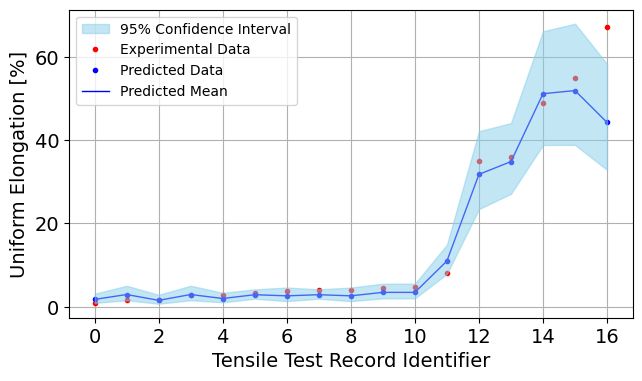

Run # 1 Fold # 4
[iter 0] loss=4.4948 val_loss=4.0742 scale=2.0000 norm=2.3105
[iter 100] loss=3.8096 val_loss=3.2285 scale=2.0000 norm=1.1968
[iter 200] loss=3.3189 val_loss=2.7882 scale=2.0000 norm=1.0107
[iter 300] loss=2.8509 val_loss=2.4535 scale=2.0000 norm=0.9735
== Early stopping achieved.
== Best iteration / VAL378 (val_loss=2.3535)
Pearson CC: 0.988774129594401
R2 score: 0.9728990872589783
RMSE: 2.82082182116124
MAE: 2.088654982251018
Coverage: 94.11764705882354
Median Interval Width: 11.339482877262164
Composite Metric: 0.727929213693645


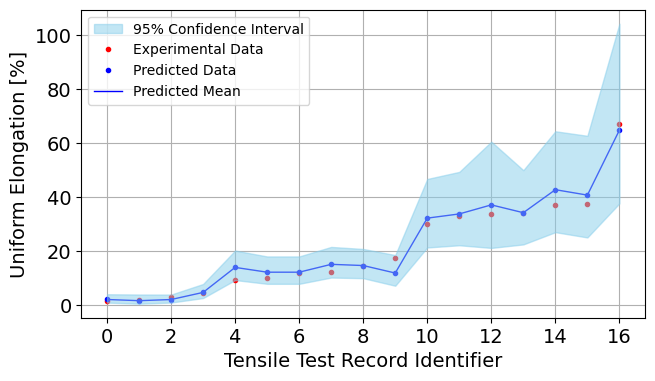

Run # 1 Fold # 5
[iter 0] loss=4.3784 val_loss=3.8655 scale=2.0000 norm=2.3205
[iter 100] loss=3.7084 val_loss=3.0655 scale=2.0000 norm=1.2082
[iter 200] loss=3.2312 val_loss=2.6170 scale=2.0000 norm=1.0148
[iter 300] loss=2.7866 val_loss=2.2366 scale=2.0000 norm=0.9635
[iter 400] loss=2.3899 val_loss=2.0195 scale=2.0000 norm=0.9173
== Early stopping achieved.
== Best iteration / VAL440 (val_loss=2.0022)
Pearson CC: 0.9837003540745501
R2 score: 0.9500646315690745
RMSE: 4.73714773875775
MAE: 3.2894688277232453
Coverage: 94.11764705882354
Median Interval Width: 21.75116203111588
Composite Metric: 0.7173759917473408


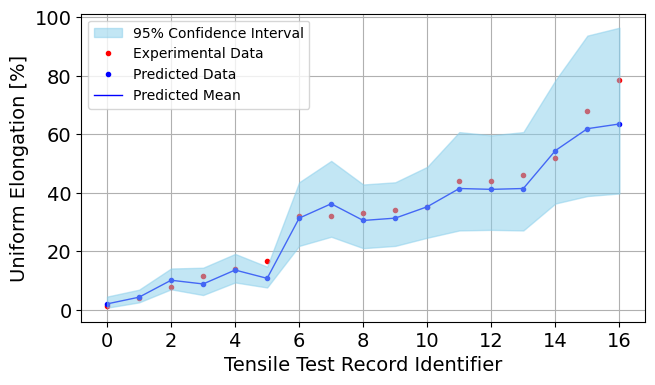

In [81]:
from ngboost import NGBRegressor
from ngboost.distns import Exponential, Normal, LogNormal
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)
MAPE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
upper_coverage = np.zeros_like(PearsonCC)
lower_coverage = np.zeros_like(PearsonCC)
mean_interval_width = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)
for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):
            
            # Display the run number
            print('Run #', j+1, "Fold #", i+1)
            
            X_train, X_test = features.iloc[tr], features.iloc[ts]

            scale = MinMaxScaler()
            X_train = scale.fit_transform(X_train)
            X_test = scale.transform(X_test)

            y_train, y_test = targets[tr], targets[ts]
            X_train, X_val, y_train, Y_val =train_test_split(X_train, y_train, test_size=0.2, random_state=42)
            
            
            model = NGBRegressor(Dist=LogNormal, n_estimators=1000, learning_rate=0.005)

            model.fit(X_train, y_train, X_val=X_val, Y_val=Y_val, early_stopping_rounds=4)

            y_pred_test = model.predict(X_test)
            
            y_test_ngb = model.pred_dist(X_test)

            PearsonCC[j, i] = pearsonr(y_test, y_pred_test)[0]
            R2_score[j, i] = r2_score(y_test, y_pred_test)
            RMSE[j, i] = sqrt(mean_squared_error(y_pred_test, y_test))
            MAE[j, i] = np.mean(abs(y_pred_test-y_test))
            
            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')
            
            df_test_low = y_test_ngb.interval(0.95)[0]
            df_test_median = y_pred_test
            df_test_high = y_test_ngb.interval(0.95)[1]
            
            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high) 
            print(f'Coverage: {test_coverage[j, i]}')

            # Prediction interval width
            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Median Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            # Plot the predictions
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            y_pred = y_pred_test
            y_std = np.std(np.array(y_pred_test), axis=0)

            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, df_test_low, df_test_high, alpha=0.5, color='skyblue', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ro', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, y_pred, 'bo', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="blue", label="Predicted Mean")
            ax[0].legend(fontsize=10, frameon=True, loc="upper left")
            ax[0].set_xlabel("Tensile Test Record Identifier", fontsize=14)
            ax[0].set_ylabel("Uniform Elongation [%]", fontsize=14)
            ax[0].tick_params(axis='both', which='major', labelsize=14)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.8')
            fig.delaxes(ax[1])

            plt.show()